# Trading Agent Development
Inspiration:
- https://www.backtrader.com/blog/posts/2015-08-16-backtesting-with-almost-no-programming/backtesting-with-almost-no-programming/ (Backtrader Platform würde einige Funktionen bereitstellen)
- https://github.com/tmorgan4/btgym_Kismuz?tab=readme-ov-file
- 

In [1]:
import src.utils.file_management as filemgmt
import src.pipeline.preprocessing as prep
import src.pipeline.predictors as predictors
from src.pipeline.predictors import LSTMPredictor

import gym
from gym import spaces
from typing import Union, Literal
import numpy as np
import pandas as pd
import random
import enum

from pathlib import Path

from tqdm import tqdm
from alpha_vantage.timeseries import TimeSeries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from matplotlib.lines import Line2D

import matplotlib.pyplot as plt

## Initialisation

In [2]:
ROOT = Path().resolve().parent

DATA = ROOT / "data"
INTERPOLATED_PRICES = DATA / "interpolated_prices"

SAVED_MODELS = DATA / "saved_models"

In [3]:
SAVED_B1_PREDICTOR = SAVED_MODELS / "predictor_b1" / "2025-05-22 10_03_41 LSTM Model RW68 FH14 Layers3 Size256 TrainL0.10641186928842217 ValL1.9110333621501923 TrainHR0.4860040545463562 ValHR0.5328466892242432.pt"
B1_PRICE_FILE = filemgmt.most_recent_file(INTERPOLATED_PRICES, '.csv', '60min')

## Predictors

In [4]:
b1_predictor = LSTMPredictor(model_load_file_path=SAVED_B1_PREDICTOR,  # based on this, the predictor infers the model's properties
                             price_csv_path=B1_PRICE_FILE,
                             daily_prediction_hour=20,  # these are necessary data properties which still need to be set
                             predict_before_daily_prediction_hour=True,
                             rolling_window_size=68,
                             forecast_horizon=14, )
b1_predictor

No training epochs defined upon initialisation. Define LSTMPredictor.n_train_epochs to start training procedure.
Created rolling window view based on rolling_window_size of 68 and forecast_horizon of 14 with a time unit of 15 minutes.
Target values start at last observation before 20:00 daily.
Resulting dataset consists of 38335 observations.
Using last 20.0% of data for validation. Other data for training.
This yields 0 training and 0 validation observations.


------------------- LSTMPredictor Instance -------------------

Data Attributes:
- sampling rate in minutes: 15
- daily prediction hour: 20:00
- predicting at last observation before prediction hour: True
- rolling window size: 68
- forecast horizon: 14
- validation split: 0.2
- amount of training observations: 0
- amount of validation observations: 0

Model Attributes:
- hidden LSTM layers: 256
- number of LSTM layers: 3
- pre LSTM fully connected layer: False

Model wasn't trained yet (or was imported).

### Example Prediction

Prices are expected to go UP!


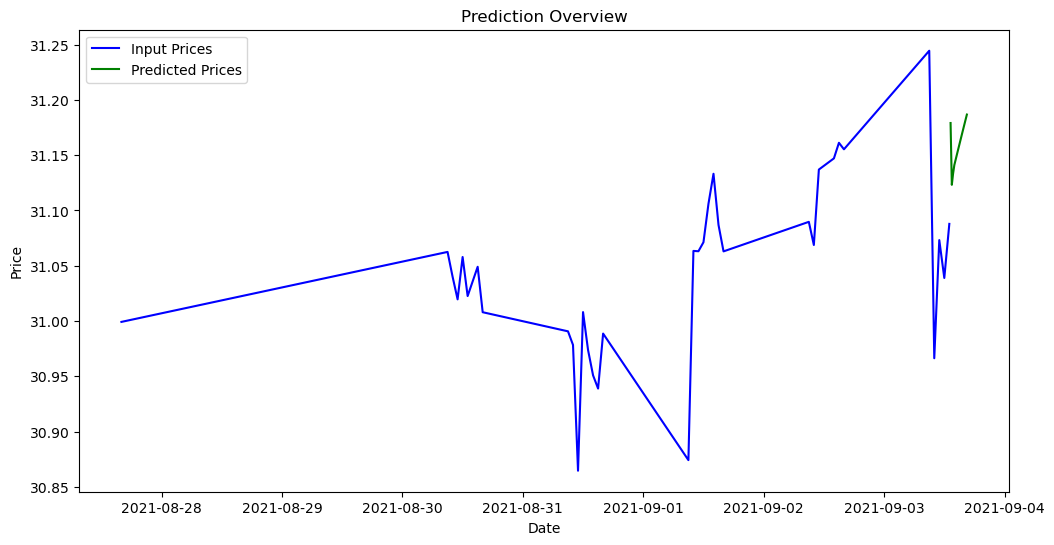

In [5]:
example_prices = LSTMPredictor.read_price_csv(B1_PRICE_FILE).iloc[25000:25068]
prices, dates, tendency = b1_predictor.predict(input_values=np.array(example_prices), input_dates=np.array(example_prices.index), return_tendency=True)

## Environment
https://github.com/tmorgan4/btgym_Kismuz/blob/master/btgym/strategy/base.py

In [13]:
class TradingActionsAll(enum.Enum):
    """ Actions for trading. Buy or sell all. No amount possible. """
    Hold = 0
    Buy = 1
    Sell = 2

In [ ]:
# Todo: observation space with predictor data

In [14]:
class RLTradingEnv(gym.Env):
    """ A trading environment for OpenAI gym """
    metadata = {'render.modes': ['human']}
    def __init__(self,
                 price_csv_path: Union[str, Path],
                 price_column='close',
                 date_column='date',
                 # Todo: possible_products (which certificates)  # used to define action space
                 possible_trade_quantities: Literal['all', 'fixed', 'arbitrary'] = 'all',  # used to define action space
                 starting_cash=100000,
                 commission_rate=0,
                 sample_days=30,
                 random_on_reset=True,
                 verbose=True
                 ):
        """
        Represents the initialization method for the RLTradingEnv class, where key
        parameters related to the trading environment such as data frames, pricing
        information, initial cash balance, commission rate, and sampling days
        are set upon instantiation.

        TO BE DESCRIBED!
        :param starting_cash: The initial amount of cash available in the environment
            for trading (at beginning of every episode).
        :param commission_rate: The commission or transaction fee rate applied to
            each trade. Represented as a decimal value, where 0.01 corresponds to
            a 1% transaction cost.
        :param sample_days: Number of previous days that are observable to the agent in each episode.
        :param random_on_reset: whether each episode randomly selects a stock to train
        """
        super(RLTradingEnv, self).__init__()  # initialise base class
        self.price_series = LSTMPredictor.read_price_csv(csv_path=price_csv_path, date_column=date_column, price_column=price_column)
        self.price_column = price_column
        self.date_column = date_column

        self.starting_cash = starting_cash
        self.commission_rate = commission_rate
        self.sample_days = sample_days
        self.random_on_reset = random_on_reset
        self.verbose = verbose

        # current episode (sequence of steps)
        self.cur_episode = self.next_episode() if random_on_reset else 0

        # current step (status and actions)
        self.cur_step = self.sample_days

        # set of possible actions as discrete values:
        if possible_trade_quantities == 'all':
            self.action_space = spaces.Discrete(len(TradingActionsAll))
        elif possible_trade_quantities == 'fixed':
            raise NotImplementedError("Fixed trading quantities are yet to be implemented.")
        elif possible_trade_quantities == 'arbitrary':
            raise NotImplementedError("Arbitrary trading quantities are yet to be implemented.")
        else:
            raise ValueError("possible_trade_quantities can only be 'all', 'fixed', 'arbitrary'")

        # set of floats representing available information for agent:
        self.observation_space = spaces.Box(low=-np.inf,
                                            high=np.inf,
                                            shape=(len(self.indicator_columns) * self.sample_days + 3,),
                                            dtype=np.float16)
        # contains indicator columns and three more for (cash, price and action)

        # possible range of rewards for actions:
        self.reward_range = (-np.inf, np.inf)

        # initial conditions:
        self.cash = self.starting_cash
        self.shares = 0

    def step(self, action):
        """
        Execute an action, return the reward and move to the next status.
        Takes action.
        Returns observation (box), reward (float), done (bool, indicating whether episode is finished) and info (dict).
        """
        # infer current balance:
        balance = self.cur_balance

        # increase step and check if episode is finished (adjust cur_step and cur_episode)
        self.cur_step += 1
        if self.cur_step == self.total_steps:
            self.cur_episode = self.next_episode()
            self.cur_step = self.sample_days

        # take action:
        self.take_action(action)

        # compute status and calculate reward:
        obs = self.next_observation(action)
        reward = self.cur_balance - balance  # equals change of balance
        done = self.cur_step == self.total_steps - 1  # see if episode is finished

        # construct info dictionary:
        info = { 'Step'  : self.cur_step,
                 'Reward' : round(reward, 2),
                 'Symbol' : self.cur_symbol,
                 'Action' : TradingActionsAll(action).name,
                 'Shares' : self.shares,
                 'Close'  : round(self.cur_close_price, 2),
                 'Cash'   : round(self.cash, 2),
                 'Total'  : round(self.cur_balance, 2) }

        # if done: self.reset()  # happens automatically!

        return obs, reward, done, info

    def take_action(self, action):
        """ Takes action and updates current balance. Hold has no implication. Considers commission_rate """
        if action == TradingActionsAll.Buy.value:  # buy all:
            if self.shares == 0:  # only if no shares held:
                price = self.cur_close_price * (1 + self.commission_rate)
                self.shares = int(self.cash / price)
                self.cash -= self.shares * price
                if self.verbose:
                    print(f"[STEP {self.cur_step}] Bought {self.cur_symbol} at {self.cur_close_price}")
                    print(f"    Cash: {self.cash}, Shares: {self.shares}")
        elif action == TradingActionsAll.Sell.value:  # sell all:
            if self.shares > 0:  # only if there are shares to sell:
                price = self.cur_close_price * (1 - self.commission_rate)
                self.cash += self.shares * price
                self.shares = 0
                if self.verbose:
                    print(f"[STEP {self.cur_step}] Sold {self.cur_symbol} at {self.cur_close_price}")
                    print(f"    Cash: {self.cash}, Shares: {self.shares}")

    def next_observation(self, action):
        """ Construct and return new observable status. Reads current indicators (for sample_days), cash, balance and action. """
        observation = np.array([], dtype=np.int64)
        for i in range(self.sample_days, 0, -1):
            observation = np.append(observation, list(self.cur_indicators.iloc[self.cur_step - i + 1, :]))
        return np.append(observation, [self.cash, self.shares * self.cur_close_price, action])

    def next_episode(self):
        """ Select stock to be trained at beginning of episode. """
        if self.random_on_reset:
            return random.randrange(0, self.total_episodes)
        else:
            return (self.cur_episode + 1) % self.total_episodes

    def reset(self):
        """ Initialises environment when starting new episode. Returns next status. """
        if self.verbose:  # info statement
            print(f"Starting episode {self.cur_episode + 1}", (f"/{self.total_episodes}" if not self.random_on_reset else ""))
        self.cash = self.starting_cash
        self.shares = 0
        return self.next_observation(TradingActionsAll.Hold.value)

    ################ properties ################
    @property
    def total_episodes(self):
        """ Total episodes equals amount of provided stock data frames. """
        return len(self.data_frame_dict)

    @property
    def cur_symbol(self):
        """ Current symbol is the key of the current episode's data frame. """
        return list(self.data_frame_dict.keys())[self.cur_episode]

    @property
    def cur_data(self):
        """ Current data is the current episode's data frame. '"""
        return self.data_frame_dict[self.cur_symbol]

    @property
    def cur_indicators(self):
        """ Current indicators are the technical indicators in the current data. """
        return self.cur_data[self.indicator_columns]

    @property
    def total_steps(self):
        """ Total steps equals length of current stock data frame."""
        return len(self.cur_data)

    @property
    def cur_close_price(self):
        """ Current close price is the price of the current symbol at current time. """
        return self.cur_data[self.price_column].iloc[self.cur_step].item()

    @property
    def cur_balance(self):
        """ Current balance equals cash plus current shares times current price. """
        return self.cash + (self.shares * self.cur_close_price)